In [10]:
import json
from pprint import pprint as pp

import numpy as np
import matplotlib.pyplot as plt

import networkx as nx

from braket.aws import AwsDevice
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from braket.devices import LocalSimulator

from quera_ahs_utils.plotting import show_global_drive, show_register
from quera_ahs_utils.drive import get_drive

from iquhack_utils import (
    find_UDG_radius,
    visualize_graph,
    get_blockade_radius,
    get_graph_from_blockade_radius,
    C6,
    save_result_json,
    open_json,
)

from utils import postprocess_MIS, analysis_MIS

In [11]:
plt.rcParams["figure.dpi"] = 140

In [12]:
qpu = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")
capabilities = qpu.properties.paradigm
pp(capabilities.dict())

C6 = float(capabilities.rydberg.dict()['c6Coefficient']) # rad m^6/sec

{'braketSchemaHeader': {'name': 'braket.device_schema.quera.quera_ahs_paradigm_properties',
                        'version': '1'},
 'lattice': {'area': {'height': Decimal('0.000076'),
                      'width': Decimal('0.000075')},
             'geometry': {'numberSitesMax': 256,
                          'positionResolution': Decimal('1E-7'),
                          'spacingRadialMin': Decimal('0.000004'),
                          'spacingVerticalMin': Decimal('0.000004')}},
 'performance': {'lattice': {'positionErrorAbs': Decimal('1E-7')},
                 'rydberg': {'rydbergGlobal': {'rabiFrequencyErrorRel': Decimal('0.02')}}},
 'qubitCount': 256,
 'rydberg': {'c6Coefficient': Decimal('5.42E-24'),
             'rydbergGlobal': {'detuningRange': (Decimal('-125000000.0'),
                                                 Decimal('125000000.0')),
                               'detuningResolution': Decimal('0.2'),
                               'detuningSlewRateMax': Decimal(

In [13]:
def lieb_lattice(num_rows=1, num_columns=1):
    points = []

    for x in range(1, (num_columns + 1) * 2, 2):
        for y in range(1, (num_rows + 1) * 2, 2):
            center = np.array([x, y])
            points.append(center)
            points.append(center + np.array([0, 1]))
            points.append(center + np.array([0, -1]))
            points.append(center + np.array([1, 0]))
            points.append(center + np.array([-1, 0]))

    points = np.unique(np.array(points), axis=0)

    return points

# Points: 100


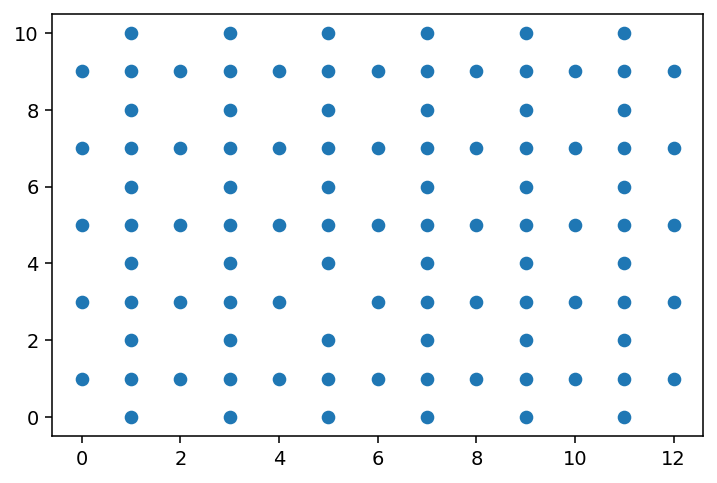

In [14]:
points = lieb_lattice(num_rows=4, num_columns=5)
points = np.delete(points, 40, axis=0)

print(f"# Points: {len(points)}")
plt.scatter(*zip(*(points)))
plt.show()

Blockade Radius: 6.385e-06.
Unit Disk Radius: 1.030.


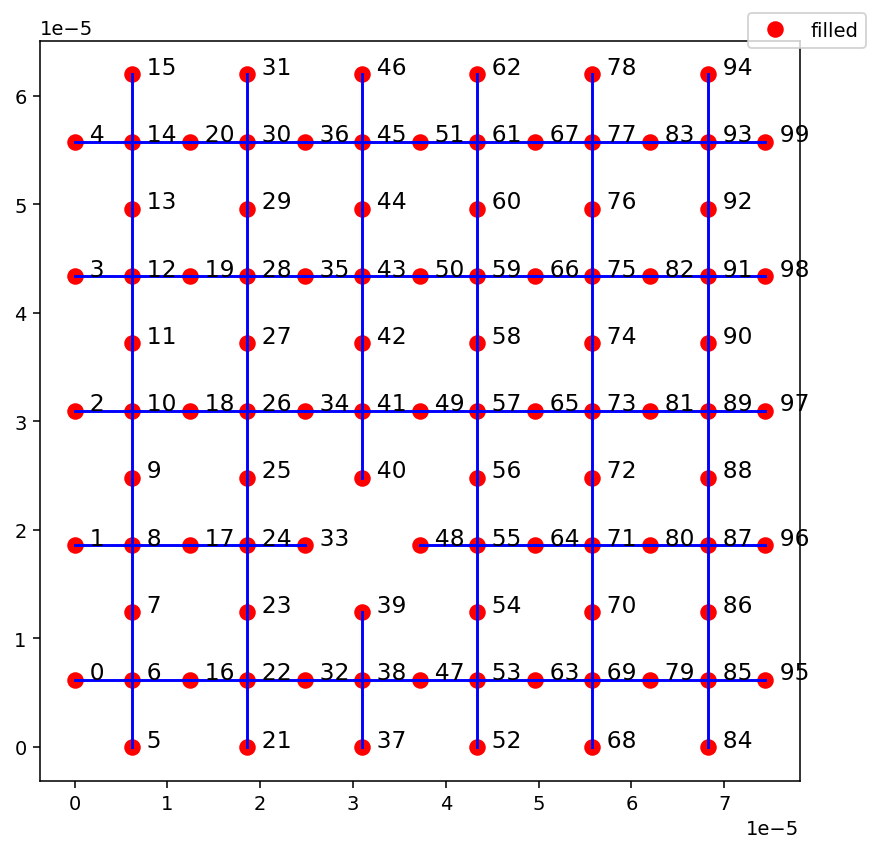

In [17]:
detuning_final = 80e6  # rad/sec
unitdisk_radius = 1.03

blockade_radius = get_blockade_radius(detuning_final, 0)
print(f"Blockade Radius: {blockade_radius:0.3e}.")
print(f"Unit Disk Radius: {unitdisk_radius:0.3f}.")

a = blockade_radius / unitdisk_radius

register = AtomArrangement()
for x in points:
    register.add((a * np.array(x)).round(7))
graph, _ = get_graph_from_blockade_radius(register, blockade_radius)

show_register(register, blockade_radius=blockade_radius)

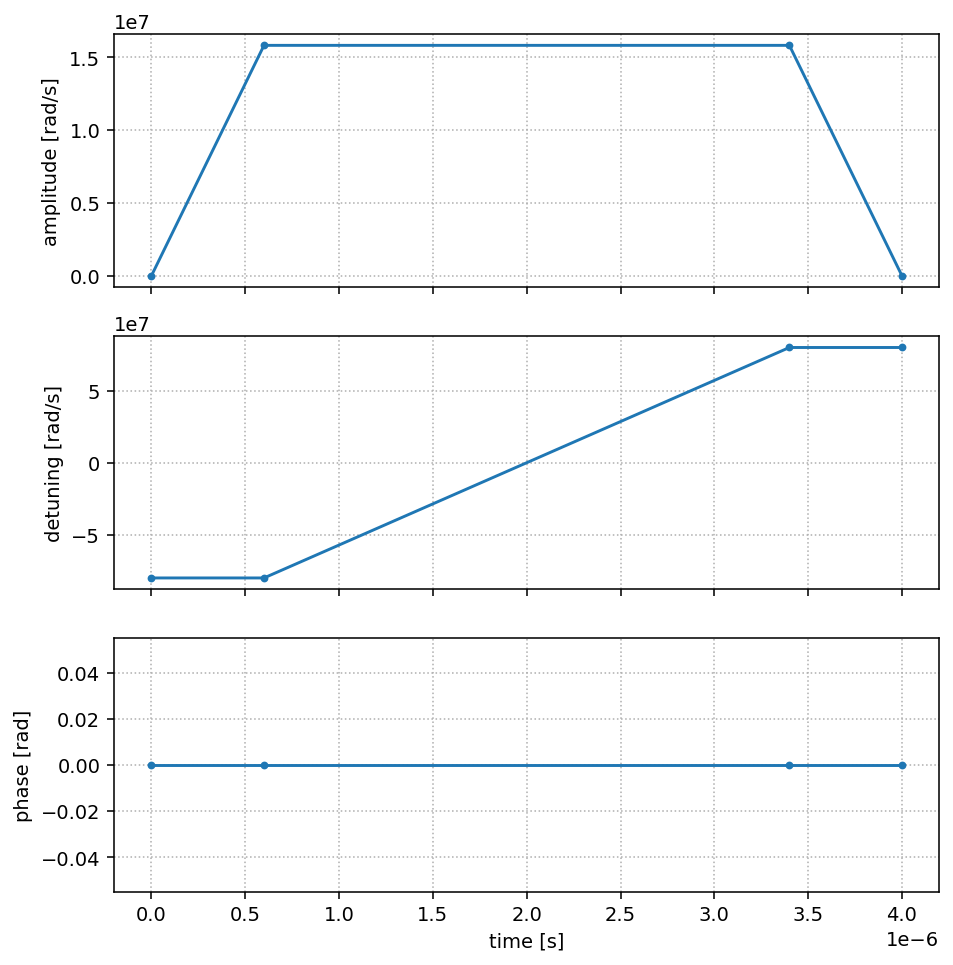

In [18]:
time_points = [0, 0.6e-6, 3.4e-6, 4e-6]

amplitude_min = 0
amplitude_max = 15.8e6  # rad / sec

detuning_initial = -detuning_final  # rad / sec
detuning_final = detuning_final

amplitude_values = [
    amplitude_min,
    amplitude_max,
    amplitude_max,
    amplitude_min,
]  # piecewise linear

detuning_values = [
    detuning_initial,
    detuning_initial,
    detuning_final,
    detuning_final,
]  # piecewise linear

phase_values = [0, 0, 0, 0]  # piecewise constant

drive = get_drive(time_points, amplitude_values, detuning_values, phase_values)
show_global_drive(drive)

In [19]:
ahs_program = AnalogHamiltonianSimulation(register=register, hamiltonian=drive)

Average pre-processed size:  64.6000
Average post-processed IS size: 67.3333


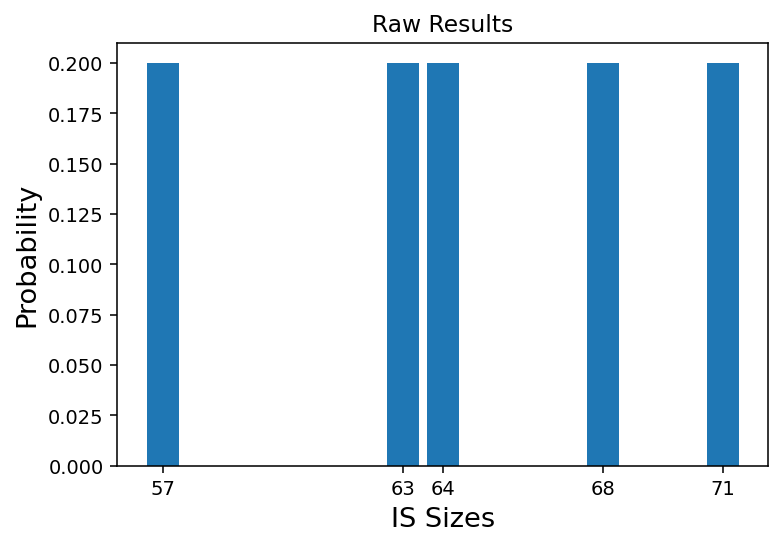

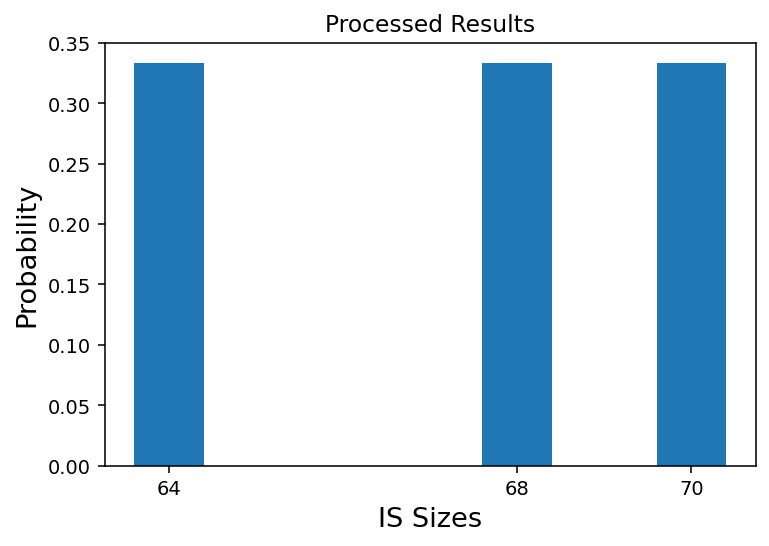

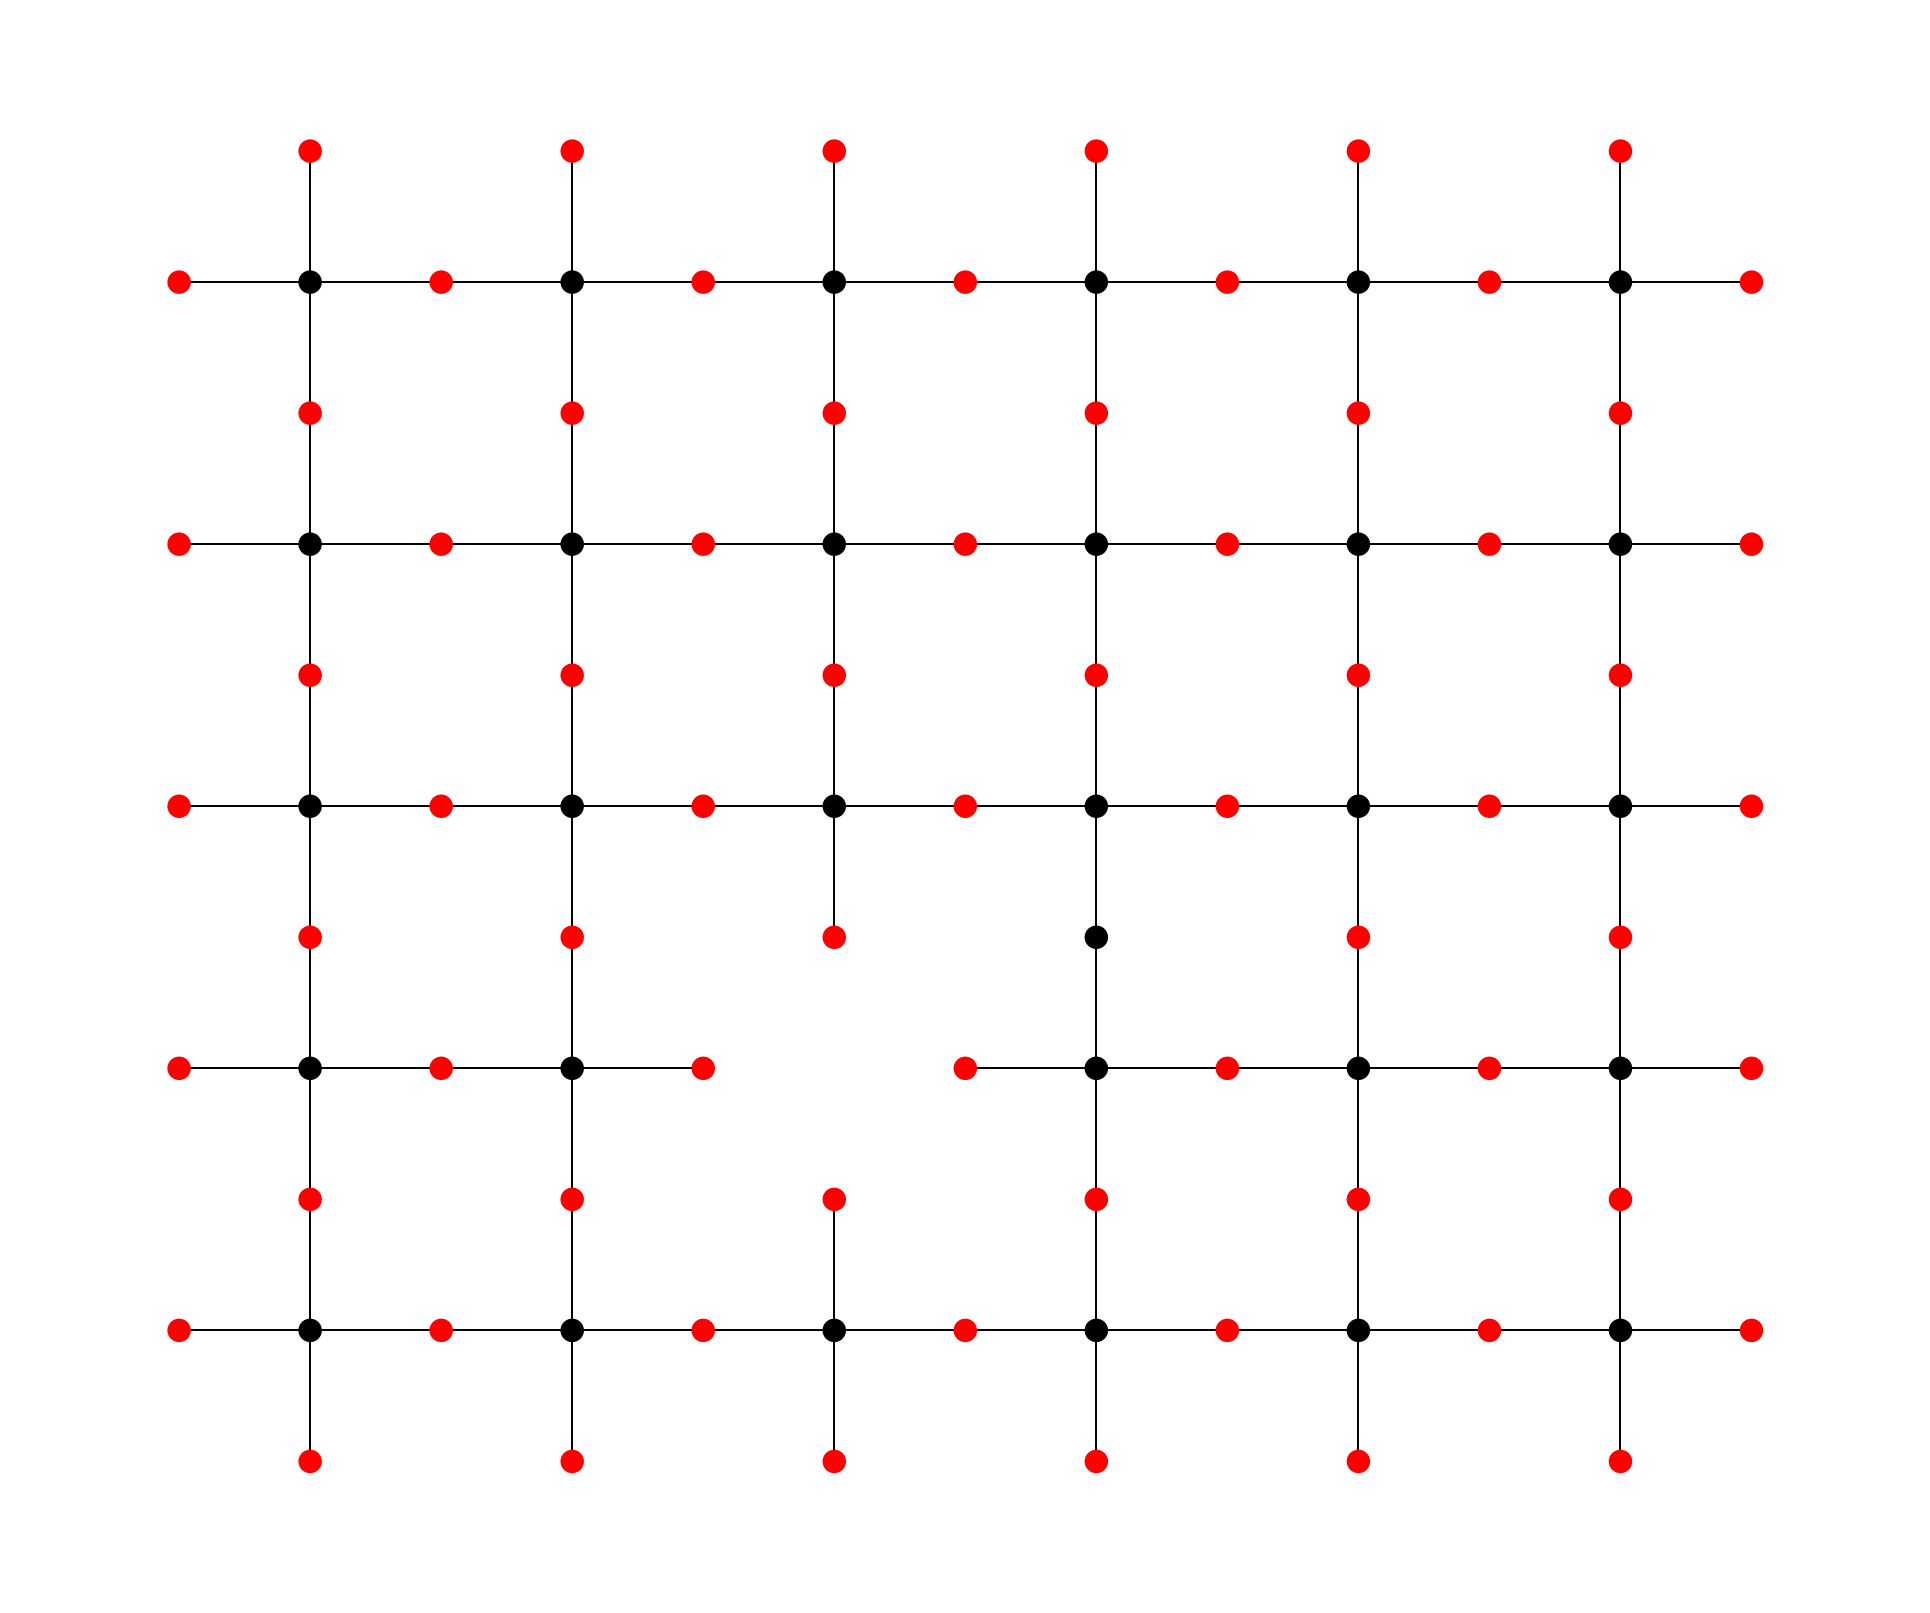

In [21]:
results_filename = "5_shots.json"
result_json = open_json(results_filename)

independent_set_sizes, raw_bitstrings = analysis_MIS(graph, result_json)

(max_indices,) = np.where(independent_set_sizes == independent_set_sizes.max())
num_shown = min(len(independent_set_sizes), 1)

figure = plt.figure(figsize=(25, 15))
for i in range(num_shown):
    axes = plt.subplot(1, num_shown, i + 1)
    color_lookup = {0: "r", 1: "k"}
    seqs_color = [
        color_lookup[raw_bitstrings[max_indices[i]][j]]
        for j in range(len(raw_bitstrings[max_indices[i]]))
    ]
    visualize_graph(
        axes, graph, {a: points[a] for a in range(len(points))}, node_colors=seqs_color
    )
plt.show()